# Unsupervised Image-image Translation(UNIT) TensorFlow Implementation

In [1]:
import tensorflow as tf
from collections import OrderedDict

/home/praveen/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
#Funciton to chose the activation function
def activate(linear, activation='leaky_relu'):
        if activation == 'sigmoid':
            return tf.nn.sigmoid(linear)
        elif activation == 'softmax':
            return tf.nn.softmax(linear)
        elif activation == 'tanh':
            return tf.nn.tanh(linear)
        elif activation == 'relu':
            return tf.nn.relu(linear)
        elif activation == 'leaky_relu':
            return tf.nn.leaky_relu(linear)
        elif activation == 'linear':
            return linear

In [3]:
def gaussian_noise_layer(input_layer, std=1.0):
    noise = tf.random_normal(shape=tf.shape(input_layer), mean=0.0, stddev=std, dtype=tf.float32) 
    return tf.add(input_layer, noise)

In [4]:
def batch_normalization_layer(input_layer):
    
    dimension = input_layer.get_shape().as_list()[-1]
    
    mean, variance = tf.nn.moments(input_layer, axes=[0, 1, 2])
    
    beta = tf.Variable(tf.constant(0.0, shape=[dimension]))
    
    gamma = tf.Variable(tf.constant(1.0, shape=[dimension]))

    bn_layer = tf.nn.batch_normalization(input_layer, mean, variance, beta, gamma, variance_epsilon=1e-10)

    return bn_layer

In [210]:
def create_conv_layer(input_layer,     # The previous layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=False,  
                   pad = [],
                   strides=[1,1,1,1],
                   deconv=False,
                   out_shape = [],      # Output shape in case of deconv 
                   batch_normalization=False,
                   activation='leaky_relu'): # Use 2x2 max-pooling.

    
    num_input_channels = input_layer.get_shape().as_list()[-1]
    # Shape of the filter-weights for the convolution. 
    # This format is determined by the TensorFlow API.
    if deconv:
        shape = [filter_size, filter_size, num_filters, num_input_channels]
    else:
        shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = tf.Variable(tf.truncated_normal(shape, stddev=0.05))

    # Create new biases, one for each filter.
    biases = tf.Variable(tf.constant(1.0, shape=[num_filters]))

    if len(pad) > 0:
        input_layer = tf.pad(input_layer, [[0, 0], [pad[0], pad[0]], [pad[1], pad[1]], [0, 0]], "CONSTANT")
    else:
        pad = [0,0]
    # Create the TensorFlow operation for de-convolution.
    if deconv:
        #in_shape = input_layer.get_shape().as_list()
        in_shape = tf.shape(input_layer)
    
        out_h = ((in_shape[1] - 1) * strides[1]) + filter_size - 2 * pad[0]
        
        out_w = ((in_shape[2] - 1) * strides[2]) + filter_size - 2 * pad[1]
        
        output_shape = tf.stack([in_shape[0], out_h, out_w, num_filters])
        
        layer = tf.nn.conv2d_transpose(value=input_layer, 
                                       filter=weights, 
                                       output_shape=output_shape, 
                                       strides=strides, 
                                       padding='SAME')
        
    else:
        layer = tf.nn.conv2d(input=input_layer,
                         filter=weights,
                         strides=strides,
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer = tf.add(layer,biases)

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Batch normalization
    if batch_normalization:
        layer = batch_normalization_layer(layer)
    
    # Activation of the layers (ReLU).
    layer = activate(layer, activation=activation)

    return layer

In [211]:
def create_res_block(X, filter_size=3, num_filters=3):
    
    num_filters = X.get_shape().as_list()[-1]
    
    layer_conv1 = create_conv_layer(input_layer=X,
                                   filter_size=filter_size,
                                   num_filters=num_filters,
                                   use_pooling=False,
                                   batch_normalization=True,
                                   activation='relu')
    
    layer_conv2 = create_conv_layer(input_layer=layer_conv1,
                                   filter_size=filter_size,
                                   num_filters=num_filters,
                                   use_pooling=False,
                                   batch_normalization=False,
                                   activation='linear')
    
    layer_conv2 = batch_normalization_layer(layer_conv2)
    
    layer_conv2 += X
    
    layer_res = activate(layer_conv2, activation='relu')
    
    return layer_res

In [286]:
def create_encoder(X, layer_n, res_block_n):
    
    num_filters = X.get_shape().as_list()[-1]
    
    encoder = OrderedDict()
    
    encoder['layer_conv1'] = create_conv_layer(input_layer=X,
                                       num_filters=num_filters,
                                       filter_size=7,
                                       strides=[1,1,1,1])
    
    for i in range(1, layer_n):
        
        encoder['layer_conv'+str(i+1)] = create_conv_layer(encoder[next(reversed(encoder))],
                                       num_filters=num_filters*2,
                                       filter_size=3,
                                       strides=[1,2,2,1])
        
        num_filters = num_filters*2
        
    for i in range(0, res_block_n):
        encoder['block_en_res'+str(i+1)] = create_res_block(encoder[next(reversed(encoder))],
                                                           num_filters=num_filters)
        
    return encoder#[next(reversed(encoder))]

In [287]:
def create_shared_layers(X, block_shared_n):
    encoder_shared = OrderedDict()
    decoder_shared = OrderedDict()
    
    encoder_shared_ = create_res_block(X)
    encoder_shared['block_shared_res1'] = gaussian_noise_layer(encoder_shared_)
    
    for i in range(1, block_shared_n+1):
        encoder_shared_ = create_res_block(encoder_shared[next(reversed(encoder_shared))])
        encoder_shared['block_shared_res'+str(i+1)] = gaussian_noise_layer(encoder_shared_)
    
    decoder_shared['block_shared_res1'] = create_res_block(encoder_shared[next(reversed(encoder_shared))])
    
    for i in range(1, block_shared_n+1):
        decoder_shared['block_shared_res'+str(i+1)] = create_res_block(decoder_shared[next(reversed(decoder_shared))])
        
    return decoder_shared#[next(reversed(decoder_shared))]

In [760]:
def create_generator(X, layer_n, res_block_n, out_shape):
    
    num_filters = X.get_shape().as_list()[-1]
    
    decoder = OrderedDict()
    
    decoder['block_res1'] = create_res_block(X, num_filters=num_filters)
        
    for i in range(1, res_block_n):
        decoder['block_res'+str(i+1)] = create_res_block(decoder[next(reversed(decoder))],
                                                           num_filters=num_filters)

    for i in range(0, layer_n-1):
        
        num_filters = num_filters//2
        
        decoder['layer_deconv'+str(i+1)] = create_conv_layer(decoder[next(reversed(decoder))],
                                       num_filters=num_filters,
                                       filter_size=2,
                                       strides=[1,2,2,1],
                                       deconv=True,
                                       batch_normalization=True,
                                       activation='relu')
    
    decoder['layer_deconv_final'] = create_conv_layer(decoder[next(reversed(decoder))],
                                       num_filters=num_filters,
                                       filter_size=1,
                                       strides=[1,1,1,1],
                                       deconv=True,
                                       activation='tanh')
    
    return decoder#[next(reversed(decoder))]

In [761]:
def create_discrimiator(X, num_filters, layer_n):
    
    discriminator = OrderedDict()
    
    discriminator['layer_discrim_conv1'] = create_conv_layer(input_layer=X,
                                       num_filters=num_filters,
                                       filter_size=3,
                                       strides=[1,2,2,1])
    
    for i in range(1, layer_n):
        
        num_filters = num_filters * 2
        
        discriminator['layer_discrim_convb'+str(i+1)] = create_conv_layer(discriminator[next(reversed(discriminator))],
                                       num_filters=num_filters,
                                       filter_size=3,
                                       strides=[1,2,2,1])
    
    return discriminator#[next(reversed(discriminator))]

In [775]:
def reshape_img(x,o_h=484,o_w=642):
    return tf.image.resize_image_with_crop_or_pad(image=x,
                                                  target_height=o_h,
                                                  target_width=o_w)

In [776]:
def compute_encoding_loss(x):
    x_2 = tf.pow(x, 2)
    encoding_loss = tf.reduce_mean(x_2)
    return encoding_loss

In [777]:
def compute_l1_loss(x,y):
    return tf.reduce_mean(tf.subtract(x,y))

In [778]:
def _compute_true_acc(predictions):
    predictions = tf.cast(tf.greater_equal(predictions, 0.5), dtype=tf.float32)
    acc = tf.reduce_sum(predictions) / tf.cast(tf.shape(predictions)[1], dtype=tf.float32)
    return acc

def _compute_fake_acc(predictions):
    predictions = tf.cast(tf.less(predictions, 0.5), dtype=tf.float32)
    acc = tf.reduce_sum(predictions) / tf.cast(tf.shape(predictions)[1], dtype=tf.float32)
    return acc

In [779]:
#Build Graph
tf.reset_default_graph()

X_A = tf.placeholder(tf.float32, shape=[1, None, None, 3], name='X_A')
X_B = tf.placeholder(tf.float32, shape=[1, None, None, 3], name='X_B')

encode_A = create_encoder(X_A, layer_n=3, res_block_n=3)
encode_B = create_encoder(X_B, layer_n=3, res_block_n=3)

encode_AB = tf.concat([encode_A[next(reversed(encode_A))], encode_B[next(reversed(encode_B))]], axis=1)

shared_in = tf.placeholder(tf.float32, shape=encode_AB.get_shape().as_list(), name='shared_in')
shared_ly = create_shared_layers(shared_in, block_shared_n=3)

decode_ch = shared_ly[next(reversed(shared_ly))].get_shape().as_list()[-1]

decode_A_in = tf.placeholder(tf.float32, shape=[1, None, None, decode_ch], name='decode_A_in')
decode_A = create_generator(decode_A_in, layer_n=3, res_block_n=3, out_shape=[1, None, None, 3])

decode_B_in = tf.placeholder(tf.float32, shape=[1, None, None, decode_ch], name='decode_B_in')
decode_B = create_generator(decode_B_in, layer_n=3, res_block_n=3, out_shape=[1, None, None, 3])

X_aa, X_ba = tf.split(decode_A[next(reversed(decode_A))], 
                      num_or_size_splits=2, axis=1)
X_ab, X_bb = tf.split(decode_B[next(reversed(decode_B))], 
                      num_or_size_splits=2, axis=1)

X_aa, X_ba, X_ab, X_bb = [reshape_img(x) for x in [X_aa, X_ba, X_ab, X_bb]]

#dis

X_ba_in = tf.placeholder(tf.float32, shape=[1, None, None, 3], name='X_ba_in')
X_ab_in = tf.placeholder(tf.float32, shape=[1, None, None, 3], name='X_ab_in')

outs_a = create_discrimiator(X_ba_in, num_filters=3, layer_n=6)
outs_b = create_discrimiator(X_ab_in, num_filters=3, layer_n=6)

In [780]:
def discriminator_update(sess, images_a, images_b, hyperparameters):
    
    encode_ab = sess.run(encode_AB, feed_dict={X_A:images_a, 
                                            X_B:images_b})
    
    shared = sess.run(shared_ly[next(reversed(shared_ly))], feed_dict={shared_in:encode_ab})
    
    x_aa, x_ba, x_ab, x_bb = sess.run([X_aa, X_ba, X_ab, X_bb], 
                                               feed_dict={decode_A_in:shared,
                                                          decode_B_in:shared})
    
    data_a = sess.run(tf.concat([images_a, x_ba], axis=1))
    data_b = sess.run(tf.concat([images_b, x_ab], axis=1))
    
    
    out_a, out_b = sess.run([outs_a[next(reversed(outs_a))], outs_b[next(reversed(outs_b))]],
                            feed_dict={X_ba_in:data_a, X_ab_in:data_b})
    
    out_a = tf.contrib.layers.flatten(out_a)
    out_b = tf.contrib.layers.flatten(out_b)
        

    out_true_a, out_fake_a = tf.split(out_a, num_or_size_splits=2, axis=1)
    
    out_true_b, out_fake_b = tf.split(out_b, num_or_size_splits=2, axis=1)
    
    all1 = tf.Variable(tf.constant(1.0, shape=out_true_a.get_shape()))
    all0 = tf.Variable(tf.constant(0.0, shape=out_fake_a.get_shape()))
    
    ad_true_loss_a = tf.nn.sigmoid_cross_entropy_with_logits(logits=out_true_a, labels=all1)
    ad_true_loss_b = tf.nn.sigmoid_cross_entropy_with_logits(logits=out_true_b, labels=all1)
    ad_fake_loss_a = tf.nn.sigmoid_cross_entropy_with_logits(logits=out_fake_a, labels=all0)
    ad_fake_loss_b = tf.nn.sigmoid_cross_entropy_with_logits(logits=out_fake_b, labels=all0)
    
    ad_loss_a = ad_true_loss_a + ad_fake_loss_a
    ad_loss_b = ad_true_loss_b + ad_fake_loss_b
    
    true_a_acc,true_b_acc,fake_a_acc,fake_b_acc = sess.run([_compute_true_acc(out_true_a),
                                                            _compute_true_acc(out_true_b),
                                                            _compute_fake_acc(out_fake_a),
                                                            _compute_fake_acc(out_fake_b)])
    
    print("True Acc:",0.5*(true_a_acc+true_b_acc)," Fake Acc:",0.5*(fake_a_acc+fake_b_acc))
                       
    cost = hyperparameters['gan_w'] * ( ad_loss_a + ad_loss_b )
                       
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001,beta1=0.5,beta2=0.999).minimize(cost)
                       
    return

In [792]:
def generator_update(sess, images_a, images_b, hyperparameters):
    
    encode_ab = sess.run(encode_AB, feed_dict={X_A:images_a, 
                                            X_B:images_b})
    
    shared = sess.run(shared_ly[next(reversed(shared_ly))], feed_dict={shared_in:encode_ab})
    
    x_aa, x_ba, x_ab, x_bb = sess.run([X_aa, X_ba, X_ab, X_bb], 
                                               feed_dict={decode_A_in:shared,
                                                          decode_B_in:shared})
    #a2b
    x_bab = sess.run(encode_A[next(reversed(encode_A))], feed_dict={X_A:x_ba})
    shared_bab = sess.run(shared_ly[next(reversed(shared_ly))], feed_dict={shared_in:x_bab})
    x_bab = sess.run(reshape_img(decode_B[next(reversed(decode_B))]), feed_dict={decode_B_in:shared_bab})
    
    #b2a
    x_aba = sess.run(encode_B[next(reversed(encode_B))], feed_dict={X_B:x_ab})
    shared_aba = sess.run(shared_ly[next(reversed(shared_ly))], feed_dict={shared_in:x_aba})
    x_aba = sess.run(reshape_img(decode_A[next(reversed(decode_A))]), feed_dict={decode_A_in:shared_aba})
    
    #dis
    out_a, out_b = sess.run([outs_a[next(reversed(outs_a))], outs_b[next(reversed(outs_b))]],
                            feed_dict={X_ba_in:x_ba, X_ab_in:x_ab})
    
    out_a = tf.contrib.layers.flatten(out_a)
    out_b = tf.contrib.layers.flatten(out_b)
    
    #loss
    all_ones = tf.Variable(tf.constant(1.0, shape=out_a.get_shape()))
    
    ad_loss_a = tf.nn.sigmoid_cross_entropy_with_logits(logits=out_a, labels=all_ones)
    ad_loss_b = tf.nn.sigmoid_cross_entropy_with_logits(logits=out_b, labels=all_ones)
    
    enc_loss  = compute_encoding_loss(shared)
    enc_bab_loss = compute_encoding_loss(shared_bab)
    enc_aba_loss = compute_encoding_loss(shared_aba)
    ll_loss_a = compute_l1_loss(x_aa, images_a)
    ll_loss_b = compute_l1_loss(x_bb, images_b)
    ll_loss_aba = compute_l1_loss(x_aba, images_a)
    ll_loss_bab = compute_l1_loss(x_bab, images_b)
    
    total_loss = hyperparameters['gan_w'] * (ad_loss_a + ad_loss_b) + \
                 hyperparameters['ll_direct_link_w'] * (ll_loss_a + ll_loss_b) + \
                 hyperparameters['ll_cycle_link_w'] * (ll_loss_aba + ll_loss_bab) + \
                 hyperparameters['kl_direct_link_w'] * (enc_loss + enc_loss) + \
                 hyperparameters['kl_cycle_link_w'] * (enc_bab_loss + enc_aba_loss)
    
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001, beta1=0.5,beta2=0.999).minimize(total_loss)
                       
    return x_aa, x_ba, x_ab, x_bb, x_aba, x_bab

In [793]:
max_epoch = 100
hyperparameters = {}

hyperparameters['gan_w'] = 10
hyperparameters['ll_direct_link_w'] = 100
hyperparameters['ll_cycle_link_w'] = 100
hyperparameters['kl_direct_link_w'] = 0.1
hyperparameters['kl_cycle_link_w'] = 0.1

In [794]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
%matplotlib inline

In [795]:
images_dir = "/home/praveen/Downloads/ezgif-4-57d76e4278-gif-jpg"

images_names = os.listdir(images_dir)

img_names = []    

for file in images_names:
    img_name = os.path.join(images_dir, file)
    img_names.append(img_name)

In [805]:
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())

    for ep in range(0):
        print(ep)
        for img_name in img_names[0:1]:
            img = cv2.imread(img_name)/255.
            images_a, images_b = np.reshape(np.array(img[:,:642,:], dtype="float32"),(1,484, 642, 3)),  \
                                    np.reshape(np.array(img[:,642:,:], dtype="float32"),(1,484, 642, 3))
        
            discriminator_update(sess, images_a, images_b, hyperparameters)
            x_aa, x_ba, x_ab, x_bb, x_aba, x_bab = generator_update(sess, images_a, images_b, hyperparameters)
            
    writer = tf.summary.FileWriter("./logs/", sess.graph)
    

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/praveen/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-805-b9cdf7748c34>", line 14, in <module>
    writer = tf.summary.FileWriter("./logs/", sess.graph)
  File "/home/praveen/anaconda3/lib/python3.6/site-packages/tensorflow/python/summary/writer/writer.py", line 336, in __init__
    filename_suffix)
  File "/home/praveen/anaconda3/lib/python3.6/site-packages/tensorflow/python/summary/writer/event_file_writer.py", line 77, in __init__
    self._flush_secs, self._sentinel_event)
  File "/home/praveen/anaconda3/lib/python3.6/site-packages/tensorflow/python/summary/writer/event_file_writer.py", line 148, in __init__
    threading.Thread.__init__(self)
  File "/home/praveen/anaconda3/lib/python3.6/threading.py", line 792, in __init__
    self._tstate_lock = None
KeyboardInterrupt

During handling of the above exceptio

KeyboardInterrupt: 

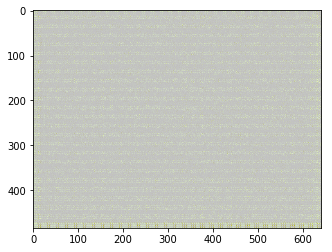

In [802]:
plt.imshow(x_bb[0])
plt.show()